In [113]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
class LaplaceSolver(object):
    def __init__(self, num_pts):
        self.x = torch.linspace(0,1,steps=num_pts)
        self.grid = torch.stack(torch.meshgrid(self.x,self.x,indexing='ij'))  # 2 x num_pts x num_pts
        self.num_pts = num_pts
        self.delta = self.x[1]-self.x[0]

    def find_boundary(self, boundary_list):
        mask = torch.zeros((self.num_pts, self.num_pts), dtype=torch.bool)

        for boundary in boundary_list:
            
            center = boundary[:-1]
            radius = boundary[-1]
            mask = torch.logical_or(mask, torch.sum((self.grid - center[:, None, None])**2, dim=0) <= radius**2)

        return mask
    
    def solve(self, boundary_list, w=1.0, max_iter=100, verbose=True):
        u = 2 * torch.rand(self.num_pts, self.num_pts) - 1
        
        obstacle_mask = self.find_boundary(boundary_list)
        
        # Create a "Total Fixed Mask" (Obstacles + Outer Frame)
        # We need to lock the outer edges (Dirichlet BCs) and the internal obstacles
        fixed_mask = obstacle_mask.clone()
        fixed_mask[0, :] = True  # Top
        fixed_mask[-1, :] = True # Bottom
        fixed_mask[:, 0] = True  # Left
        fixed_mask[:, -1] = True # Right
        
        u[fixed_mask] = 0
        
        u[obstacle_mask] = 1 

        active_idx = torch.stack(torch.where(~fixed_mask)).T
        
        for _ in tqdm(range(max_iter), disable=not verbose):
                    
            for row, col in active_idx:
                gs_est = 0.25 * (u[row-1, col] + u[row, col-1] + 
                                        u[row+1, col] + u[row, col+1])
                        
                u[row, col] = (1 - w) * u[row, col] + w * gs_est
                        
        return u
    
    def get_residual(self,solution,boundary_list,sum=True):
        conv_weight=torch.tensor([
            [0,1,0],
            [1,-4,1],
            [0,1,0]
        ],dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        res=F.conv2d(solution[None,None,:,:],conv_weight)/self.delta**2
        res=F.pad(res,pad=[1,1,1,1],mode='constant',value=0)

        mask = self.find_boundary(boundary_list)

        res *= ~mask

        if sum:
            return F.mse_loss(res,torch.zeros_like(res))

        else:
            return res.squeeze()


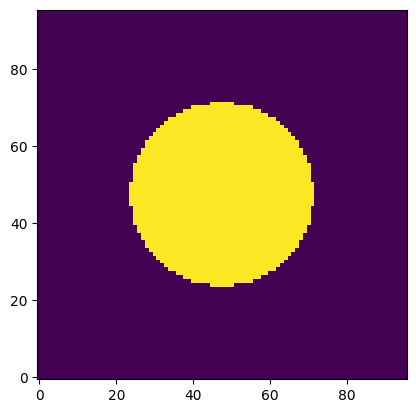

In [ ]:
solver = LaplaceSolver(num_pts=96)
boundary_list = torch.tensor(
    [[0.5,0.5,0.25]]
    # [[0.25,0.25,0.125],
    #  [0.25,0.75,0.125],
    #  [0.75,0.25,0.125],
    #  [0.75,0.75,0.125]]
    )
mask = solver.find_boundary(boundary_list)
plt.imshow(mask,origin='lower')
plt.show()

100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


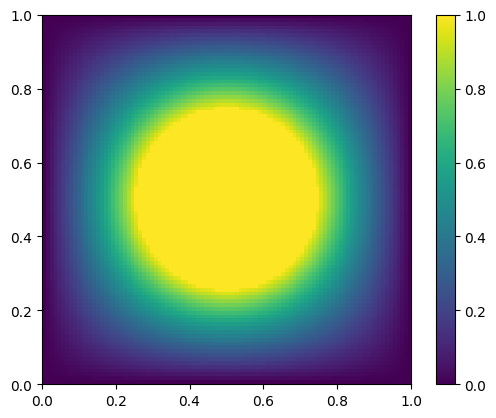

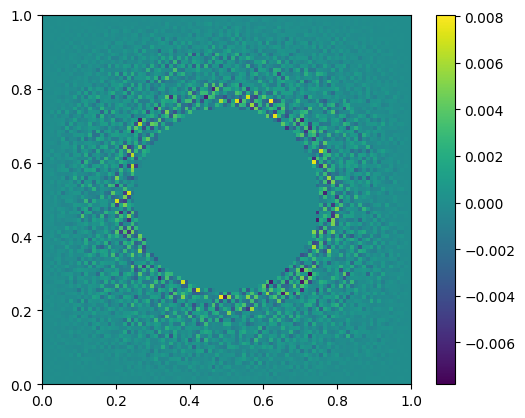

In [116]:
solution = solver.solve(boundary_list, w=1.5, max_iter=1000)
plt.imshow(solution.squeeze(),origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()
plt.imshow(solver.get_residual(solution,boundary_list,sum=False),origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()